In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from datetime import date
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [37]:
%%time
df = pd.read_feather('df_')

CPU times: user 3.74 s, sys: 8.2 s, total: 11.9 s
Wall time: 32.2 s


In [38]:
df.head()

,tripduration,starttime,stoptime,start station id,end station id,bikeid,usertype,birth year,gender,starthour,...,Snow,Fog,rain_vol,temp_level,lat1,lon1,lat2,lon2,start_cluster,end_cluster
0,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,498,21136,Subscriber,1987,2,0.0,...,0,0,0,0,40.729307,-73.990839,40.748549,-73.988084,5,1
1,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143,3152,18147,Customer,-1,0,0.0,...,0,0,0,0,40.776372,-73.964235,40.768737,-73.961199,14,14
2,631,2017-01-01 00:01:10,2017-01-01 00:11:42,3143,3152,21211,Customer,-1,0,0.0,...,0,0,0,0,40.776372,-73.964235,40.768737,-73.961199,14,14
3,621,2017-01-01 00:01:25,2017-01-01 00:11:47,3143,3152,26819,Customer,-1,0,0.0,...,0,0,0,0,40.776372,-73.964235,40.768737,-73.961199,14,14
4,559,2017-01-01 00:05:00,2017-01-01 00:14:20,499,479,27294,Subscriber,1973,1,0.0,...,0,0,0,0,40.769155,-73.981918,40.760193,-73.991255,7,7


In [39]:
df.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'end station id', 'bikeid', 'usertype', 'birth year', 'gender',
       'starthour', 'date', 'weekday', 'weekend', 'month', 'time', 'Temp_high',
       'Temp_avg', 'Temp_low', 'Precip', 'Rain', 'Snow', 'Fog', 'rain_vol',
       'temp_level', 'lat1', 'lon1', 'lat2', 'lon2', 'start_cluster',
       'end_cluster'],
      dtype='object')

In [40]:
%%time
ts_df = df[['date', 
            'Temp_high', 
            'Temp_avg', 
            'Temp_low', 
            'weekday',
            'month',
            'Precip',
            'Rain',
            'Snow',
            'Fog', 
            'rain_vol',
            'temp_level',]].copy()

ts_df['count'] = 1

CPU times: user 1.78 s, sys: 4.12 s, total: 5.91 s
Wall time: 6.83 s


In [41]:
ts_df.sample(5)

,date,Temp_high,Temp_avg,Temp_low,weekday,month,Precip,Rain,Snow,Fog,rain_vol,temp_level,count
4821386,2017-05-27,71,65,59,6,5,0.0,0,0,0,0,2,1
11586611,2017-09-23,87,78,68,6,9,0.0,0,0,0,0,4,1
13127371,2017-10-17,58,50,42,2,10,0.0,0,0,0,0,1,1
4558746,2017-05-21,69,61,52,7,5,0.0,0,0,0,0,2,1
13352181,2017-10-20,73,65,57,5,10,0.0,0,0,0,0,2,1


In [42]:
TS = ts_df.groupby('date').agg({"Temp_high": "first", 
                                "Temp_avg": "first",
                                "Temp_low": "first",
                                "weekday": "first",
                                "month": "first",
                                "Precip": "first",
                                "Rain": "first",
                                "Snow": "first",
                                "Fog": "first",
                                "rain_vol": "first",
                                "temp_level": "first",
                                "count": "sum",
                               }).reset_index()

TS['date'] = TS['date'].apply(lambda x: x.date())
TS.sample(5)
del df

In [43]:
# holidays
holidays = [date(2017, 1, 1),
            date(2017, 1, 2),
            date(2017, 1, 3),
            date(2017, 5, 29),
            date(2017, 7, 4),
            date(2017, 11, 23),
            date(2017, 12, 23),
            date(2017, 12, 24),
            date(2017, 12, 25),
            date(2017, 12, 26),
            date(2017, 12, 27),
            date(2017, 12, 28),
            date(2017, 12, 29),
            date(2017, 12, 30),
            date(2017, 12, 31),]

TS['holidays'] = 0
TS.loc[TS['date'].isin(holidays), 'holidays'] = 1

In [44]:
%%time
df = TS.copy()
df['Precip'] = df['Precip'].apply(lambda x: np.nan if x <= 0.01 else x)
df['Snow'] = df['Snow'].apply(lambda x: np.nan if x == 0 else x)

# lines
trace_close = go.Scatter(
                x=df.date,
                y=df['count'],
                name = "Daily Trip",
                line = dict(color = '#1f77b4'),
                opacity = 0.8,)

d = [[0, 'rgb(255,0,0)'], 
     [0.1, 'rgb(255,51,0)'], 
     [0.2, 'rgb(255,102,0)'], 
     [0.3, 'rgb(255,153,0)'], 
     [0.4, 'rgb(255,204,0)'], 
     [0.5, 'rgb(255,255,0)'], 
     [0.6, 'rgb(204,230,0)'], 
     [0.7, 'rgb(153,205,0)'], 
     [0.8, 'rgb(102,179,0)'], 
     [0.9, 'rgb(51,154,0)'], 
     [1.0, 'rgb(0,128,0)']]

rains = go.Scatter(
                x=df.date,
                # max Precip forced to zero
                y= -np.log(df['Precip'])+np.log(df['Precip']).max(),
                name="Inverse Rain Amount",
                text=df['Precip'],
                hoverinfo='text',
                mode='markers',
                marker=dict(
                    color=-df['Precip'],
                    size='3',
                    showscale=False,
                    colorscale=d,
                ),
                yaxis='y2',
                opacity = 0.7)

Snow = go.Scatter(
                x=df.date,
                y=df['Snow']*0,
                name="Snow",
                text='Snow',
                hoverinfo='text',
                mode='markers',
                marker=dict(
                    color="#ffb332",
                    size='5',
                    showscale=False,
                ),
                yaxis='y2',
                opacity = 0.7,
                )

temp = go.Scatter(
                x=df.date,
                # max Precip forced to zero
                y= df['Temp_avg'],
                name="Temp Avg",
                yaxis='y3',
                line = dict(color = 'grey'),
                opacity = 0.7)

# temp_l = go.Scatter(
#                 x=df.date,
#                 # max Precip forced to zero
#                 y= df['Temp_low'],
#                 name="Temp Low",
#                 yaxis='y3',
#                 line = dict(color = 'green'),
#                 opacity = 0.7)

# temp_h = go.Scatter(
#                 x=df.date,
#                 # max Precip forced to zero
#                 y= df['Temp_high'],
#                 name="Temp High",
#                 yaxis='y3',
#                 line = dict(color = 'red'),
#                 opacity = 0.7)


data = [trace_close, rains, Snow, temp] #, temp_l, temp_h]

layout = go.Layout(
    title='NYC Citi Bike 2017 Ridership Daily Average',
    xaxis=dict(
#         domain=[0.3, 0.7]
    ),
    yaxis=dict(
        title='Number of Trips',
        titlefont=dict(
            color='#1f77b4'
        ),
        tickfont=dict(
            color='#1f77b4'
        )
    ),
    yaxis2=dict(
        title='Precipitation (- log sacle)',
        overlaying='y',
        side='left',
        showgrid=False,
        showticklabels=False,
        showaxeslabels=False,
        showexponent=False,
        visible=False
    ),
    yaxis3=dict(
        title='Temperature',
        overlaying='y',
        side='right',
        showgrid=False,
#         showticklabels=False,
        showaxeslabels=False,
        showexponent=False,
#         visible=False
    ),

)
fig = go.Figure(data=data, layout=layout)
plot(fig, filename='multiple-axes-multiple.html')

CPU times: user 24 ms, sys: 63.7 ms, total: 87.7 ms
Wall time: 330 ms


In [10]:
np.corrcoef(df['Temp_avg'], df['count'])

array([[ 1.        ,  0.77501596],
       [ 0.77501596,  1.        ]])

In [11]:
np.corrcoef(df['Temp_low'], df['count'])

array([[ 1.        ,  0.73791636],
       [ 0.73791636,  1.        ]])

In [12]:
from fbprophet import Prophet

In [13]:
hh = pd.DataFrame({
  'holiday': '1',
  'ds': pd.to_datetime(holidays),
#   'lower_window': 0,
#   'upper_window': 1,
})

In [14]:
# feed into training
TS = TS.rename(columns={'date': 'ds', 'count': 'y'})

def add_weekends(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 or date.weekday() == 5:
        return 1
    else:
        return 0
    
TS['weekend'] = TS['ds'].apply(add_weekends)


# training and validation
trn_end = date(2017, 11, 1)
trn = TS[TS.ds<trn_end]
val = TS[TS.ds>=trn_end]

y_train = np.log(trn['y'])
y_val = np.log(val['y'])

X_train = trn.drop(['y', 'ds'], 1)
X_val = val.drop(['y', 'ds'], 1)

In [15]:
# Python

m = Prophet(holidays=hh)
m.add_regressor('Temp_high')
m.add_regressor('Temp_avg')
m.add_regressor('Temp_low')
m.add_regressor('weekday')
m.add_regressor('month')
m.add_regressor('Precip')
m.add_regressor('Snow')
m.add_regressor('Fog')
m.add_regressor('rain_vol')
m.add_regressor('temp_level')
m.add_regressor('weekend')
m.fit(trn)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 2.43 s, sys: 139 ms, total: 2.57 s
Wall time: 2.61 s


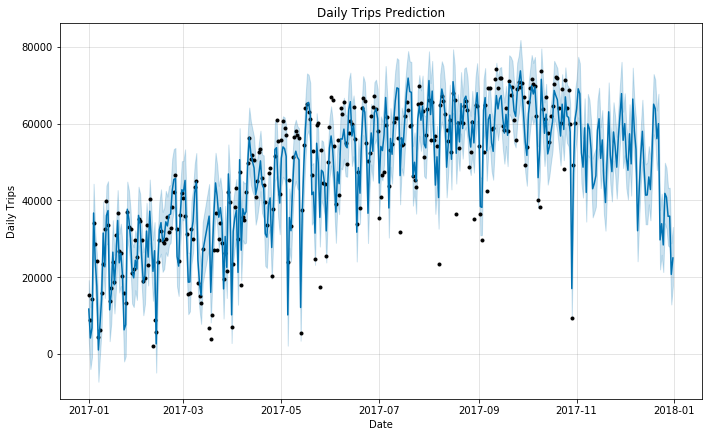

In [16]:
%%time
# Make predictions
TS_forecast = m.predict(TS)

m.plot(TS_forecast, xlabel = 'Date', ylabel = 'Daily Trips')
plt.title('Daily Trips Prediction');

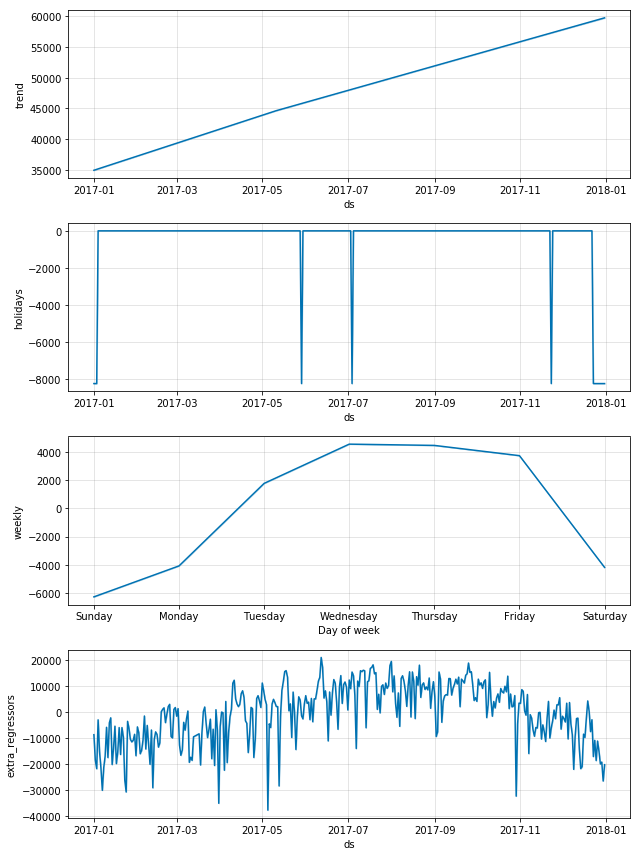

In [17]:
m.plot_components(TS_forecast);

In [19]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [20]:
pred_trn_ = TS_forecast.loc[TS_forecast['ds']<trn_end, 'yhat']
res = TS_forecast.loc[TS_forecast['ds']>=trn_end, 'yhat']


print('Training loss:', mean_squared_error(y_train, np.log(pred_trn_)) )
print('Validation loss:', mean_squared_error(y_val, np.log(res)) )
print("r^2 on test data : %f" % r2_score(y_val, np.log(res)))

Training loss: 0.0824637663419
Validation loss: 0.351857945534
r^2 on test data : 0.041690


In [21]:
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)

y_pred_trn = lr.predict(X_train)
y_pred_reg = lr.predict(X_val)
r2_score_lr = r2_score(y_val, y_pred_reg)
print('Training loss:', mean_squared_error(y_train, y_pred_trn) )
print('Validation loss:', mean_squared_error(y_val, y_pred_reg) )
print("r^2 on test data : %.4f" % r2_score_lr)

Training loss: 0.0695876077252
Validation loss: 0.068894114622
r^2 on test data : 0.8124


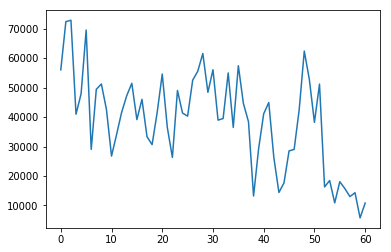

In [22]:
plt.plot(np.exp(y_pred_reg))

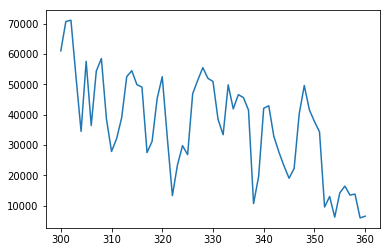

In [23]:
plt.plot(np.exp(y_val))

In [24]:
pred = lr.predict(TS.drop(['ds','y'],1))
pred = [int(np.exp(i)) for i in pred]
TS['pred'] = pred

In [25]:
TS.head(1)

,ds,Temp_high,Temp_avg,Temp_low,weekday,month,Precip,Rain,Snow,Fog,rain_vol,temp_level,y,holidays,weekend,pred
0,2017-01-01,46,44,41,7,1,0.0,0,0,0,0,0,15412,1,1,15071


In [26]:
trn_end

datetime.date(2017, 11, 1)

In [27]:
%%time

trn_tmp = TS[TS.ds<trn_end]
val_tmp = TS[TS.ds>=trn_end]

# lines
trace_actual = go.Scatter(
                x=TS['ds'],
                y=TS['y'],
                name = "Actual",
                line = dict(color = '#1f77b4'),
                opacity = 0.8,)


trace_pred_trn = go.Scatter(
                x=trn_tmp['ds'],
                y=trn_tmp['pred'],
                name = "Pred Trn",
                line = dict(color = 'green'),
                opacity = 0.5,)

trace_pred_val = go.Scatter(
                x=val_tmp['ds'],
                y=val_tmp['pred'],
                name = "Pred Val",
                line = dict(color = 'orange'),
                opacity = 0.5,)


data = [trace_actual, trace_pred_trn, trace_pred_val] 

layout = go.Layout(
    title='NYC Citi Bike 2017 Ridership Actual vs. Prediction',
    shapes = [
    # Line Vertical
        {
            'type': 'line',
            'x0': trn_end,
            'y0': 0,
            'x1': trn_end,
            'y1': 100000,
            'line': {
                'color': 'black',
                'width': 1,}},
    ],
    xaxis=dict(),
    yaxis=dict(
        title='Number of Trips',
        titlefont=dict(
            color='#1f77b4'
        ),
        tickfont=dict(
            color='#1f77b4'
        )
    ),

)
fig = go.Figure(data=data, layout=layout)
py.plot(fig, filename='multiple-axes-multiple')

CPU times: user 42.1 ms, sys: 42.9 ms, total: 85 ms
Wall time: 1.98 s


In [31]:
# iplot(fig, filename='total_num_prediction.html')
plot(fig, filename='total_num_prediction.html')

'file:///Users/Ben/MSAN/Spark_MongoDB_bike-share-spark-analysis/total_num_prediction.html'